In [13]:
import pandas as pd
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url, check_integrity
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *
from torchsummary import summary
%matplotlib inline

In [14]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision import datasets, transforms

class CIFAR10(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }


    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False, coarse=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.coarse = coarse

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            self.train_coarse_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                    if self.coarse:
                        self.train_coarse_labels += entry['coarse_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((len(self.train_data), 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
        else:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
                if self.coarse:
                    self.test_coarse_labels = entry['coarse_labels']
            fo.close()
            self.test_data = self.test_data.reshape((len(self.test_data), 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
            if self.coarse:
                coarse_target = self.train_coarse_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
            if self.coarse:
                coarse_target = self.test_coarse_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        if not self.coarse:
            return img, target
        else:
            return img, target, coarse_target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.tgz_md5)

        # extract file
        cwd = os.getcwd()
        tar = tarfile.open(os.path.join(root, self.filename), "r:gz")
        os.chdir(root)
        tar.extractall()
        tar.close()
        os.chdir(cwd)


class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]


In [15]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [16]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 

                         ]
                         )
transform_test = tt.Compose([tt.ToTensor(), 

                             ])

In [79]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [80]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels, _ = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels, _ = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc =  accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, 20),
                                        nn.ReLU(),
                                        nn.Linear(20, num_classes),
                                        ) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [81]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [82]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target, _ in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

In [88]:
train_data = CIFAR100('./data', train=True,
                transform=transform_train,
                download=True, coarse=True)
test_data = CIFAR100('./data', train=False,
                transform=transform_test,
                download=True, coarse=True)

train_length = train_data.__len__() # Length training dataset
train_indices = np.arange(train_length)
    
train_loader = torch.utils.data.DataLoader(
                        train_data, 
                        batch_size=batch_size, 
                        num_workers=2,
                        pin_memory=True,
                    )

test_loader = torch.utils.data.DataLoader(
                        test_data, 
                        batch_size=batch_size*2,
                        num_workers=2,
                        pin_memory=True
                    )
device = get_default_device()
trainloader = DeviceDataLoader(train_loader, device)
testloader = DeviceDataLoader(test_loader, device)

Files already downloaded and verified
Files already downloaded and verified


In [101]:
accuracy_list=[]
d_list=[0, 10, 20, 30, 40, 50 ,60 , 70, 80, 90]

In [102]:
for d in d_list:
    model = ResNet9(3, 100)
    if d==0:
        model.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                nn.Flatten(), # 1028 
                                nn.Linear(1028, 100)
                                ) # 1028 -> 100
    else:
        model.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                    nn.Flatten(), # 1028 
                                    nn.Linear(1028, d),
                                    nn.ReLU(),
                                    nn.Linear(d, 100),
                                    ) # 1028 -> 100

    model = to_device(model, device)
    history = [evaluate(model, testloader)]
    print(history)
    history+=fit_one_cycle(50, max_lr, model, trainloader, testloader, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    y_test, y_pred = test_label_predictions(model, device, testloader)
    ac=accuracy_score(y_test, y_pred)
    print('Accuracy score: %f' % ac)
    accuracy_list.append(ac)

[{'val_loss': 4.605464935302734, 'val_acc': 0.009903847239911556}]
Epoch [0], last_lr: 0.00005, train_loss: 3.6510, val_loss: 3.1127, val_acc: 0.2437
Epoch [1], last_lr: 0.00008, train_loss: 2.9504, val_loss: 2.7107, val_acc: 0.3182
Epoch [2], last_lr: 0.00013, train_loss: 2.5947, val_loss: 2.6219, val_acc: 0.3333
Epoch [3], last_lr: 0.00020, train_loss: 2.3534, val_loss: 2.4172, val_acc: 0.3674
Epoch [4], last_lr: 0.00028, train_loss: 2.1630, val_loss: 2.2426, val_acc: 0.4102
Epoch [5], last_lr: 0.00037, train_loss: 1.9935, val_loss: 2.1695, val_acc: 0.4292
Epoch [6], last_lr: 0.00047, train_loss: 1.8514, val_loss: 2.1083, val_acc: 0.4521
Epoch [7], last_lr: 0.00057, train_loss: 1.7232, val_loss: 2.1970, val_acc: 0.4352
Epoch [8], last_lr: 0.00067, train_loss: 1.6090, val_loss: 2.1690, val_acc: 0.4556
Epoch [9], last_lr: 0.00076, train_loss: 1.5092, val_loss: 2.1903, val_acc: 0.4549
Epoch [10], last_lr: 0.00084, train_loss: 1.4242, val_loss: 1.9585, val_acc: 0.4822
Epoch [11], last_lr

In [103]:
accuracy_list

[0.7434,
 0.6636,
 0.7087,
 0.7165,
 0.7218,
 0.7288,
 0.7361,
 0.7299,
 0.7319,
 0.7331]

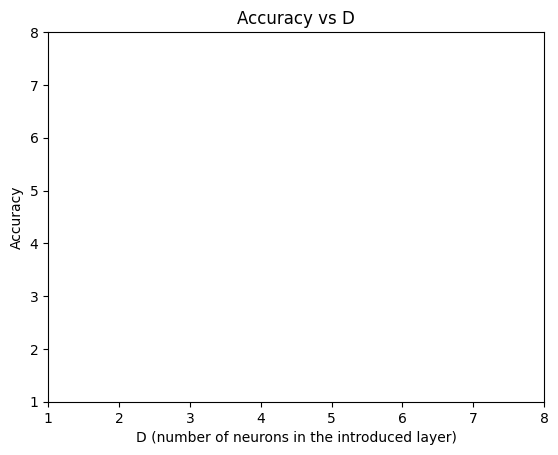

In [104]:
# # x axis values 
# x = [1,2,3,4,5,6] 
# # corresponding y axis values 
# y = [2,4,1,5,2,6] 
  
# plotting the points  
plt.plot(d_list, accuracy_list, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
  
# setting x and y axis range 
plt.ylim(1,8) 
plt.xlim(1,8) 
  
# naming the x axis 
plt.xlabel('D (number of neurons in the introduced layer)') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs D') 
  
# function to show the plot 
plt.show()

In [105]:
print(accuracy_list)

[0.7434, 0.6636, 0.7087, 0.7165, 0.7218, 0.7288, 0.7361, 0.7299, 0.7319, 0.7331]


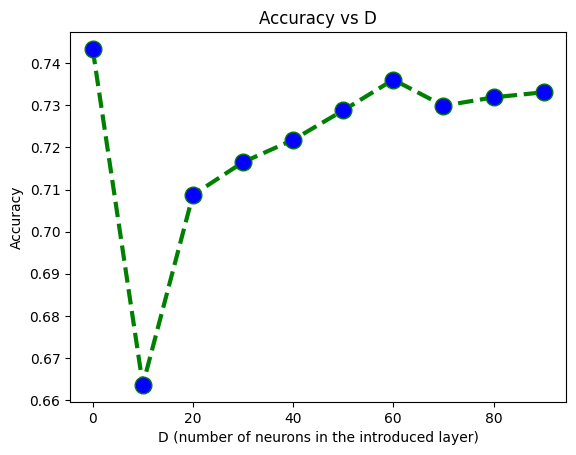

In [106]:
plt.plot(d_list, accuracy_list, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
  
# setting x and y axis range 
  
# naming the x axis 
plt.xlabel('D (number of neurons in the introduced layer)') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs D') 
  
# function to show the plot 
plt.show()

In [12]:
# Initial evaluation
history = [evaluate(model, testloader)]
history

[{'val_loss': 4.612682342529297, 'val_acc': 0.009999999776482582}]

In [13]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 4.3989, val_loss: 4.2552, val_acc: 0.0811
Epoch [1], last_lr: 0.00015, train_loss: 4.1657, val_loss: 4.0262, val_acc: 0.1381
Epoch [2], last_lr: 0.00028, train_loss: 3.8679, val_loss: 3.8434, val_acc: 0.1597
Epoch [3], last_lr: 0.00044, train_loss: 3.4173, val_loss: 3.3148, val_acc: 0.2367
Epoch [4], last_lr: 0.00060, train_loss: 2.9256, val_loss: 2.9982, val_acc: 0.2786
Epoch [5], last_lr: 0.00076, train_loss: 2.5708, val_loss: 2.9613, val_acc: 0.2962
Epoch [6], last_lr: 0.00089, train_loss: 2.3261, val_loss: 2.8279, val_acc: 0.3090
Epoch [7], last_lr: 0.00097, train_loss: 2.1256, val_loss: 2.4450, val_acc: 0.3742
Epoch [8], last_lr: 0.00100, train_loss: 1.9623, val_loss: 2.3904, val_acc: 0.3953
Epoch [9], last_lr: 0.00099, train_loss: 1.8206, val_loss: 2.6234, val_acc: 0.3569
Epoch [10], last_lr: 0.00098, train_loss: 1.7048, val_loss: 2.3221, val_acc: 0.4215
Epoch [11], last_lr: 0.00095, train_loss: 1.5919, val_loss: 2.3442, val_acc: 0.4131
Ep

In [ ]:
# Fitting the second 1/4 epochs
# history += fit_one_cycle(int(epochs/4), max_lr/10, model, trainloader, testloader, 
#                              grad_clip=grad_clip, 
#                              weight_decay=weight_decay, 
#                              opt_func=opt_func)

In [16]:
print(summary(model,(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,